In [1]:
%matplotlib inline

# Session 1: Forward mode differentiation

## Motivation

<div class="alert alert-block alert-danger">
<b>TODO</b>
</div>

#### Terminology

This course introduces the concept of *differentiable programming*, a.k.a. *automatic differentiation (AD)*, or *algorithmic differentiation*. We will use the acronym AD henceforth.

#### Notation

For a differentiable *mathematical* function $f:A\rightarrow\mathbb{R}$ with scalar input (i.e., a single value) from $A\subseteq\mathbb{R}$, we make use of both the Lagrange notation $f'(x)$ and Leibniz notation $\frac{\mathrm{d}f}{\mathrm{d}x}$ for its derivative.
We **do not** use the physics notation for derivatives, so if you ever see (e.g.) $\dot{x}$ then this is just a variable name, not the derivative of $x$.

Similarly, for $m\in\mathbb{N}$ dimensional, differentiable, vector-valued function $\mathbf{f}:A\rightarrow\mathbb{R}^m$ with scalar input, we have derivative notations $\mathbf{f}'(x)$ and $\frac{\mathrm{d}\mathbf{f}}{\mathrm{d}x}$.

For a differentiable function with vector input (i.e., multiple inputs), we use partial derivative notation. For example, if $f:\mathbb{R}^2\rightarrow\mathbb{R}$ is written as $f=f(x,y)$ then we have the partial derivatives $\frac{\partial f}{\partial x}$ and $\frac{\partial f}{\partial y}$ with respect to first and second components, respectively. We use
$$\nabla f=\left(\frac{\partial f}{\partial x_1},\dots,\frac{\partial f}{\partial x_m}\right)$$
to denote the vector of all such partial derivatives. Similarly for vector-valued functions with multiple inputs.

When it comes to derivatives in code, we use the `_d` notation, which is standard in the AD literature. Its meaning will be described in due course.

## History

* Origins of AD in 1950s.
* However, it found a wider audience in the 1980s, when it became more relevant thanks to advances in both computer power and modern programming languages.
* Forward mode (the subject of this session) was discovered by Wengert in 1964.
* Further developed by Griewank in the late 1980s.

<div class="alert alert-block alert-danger">
<b>TODO: images?</b>
</div>

## Idea

The idea of AD is to **treat a model as a sequence of elementary instructions** (e.g., addition, multiplication, exponentiation). Here a *model* could be a function or subroutine, code block, or a whole program. Elementary operations are well-understood and their derivatives are known. As such, the derivative of the whole model may be computed by composing the derivatives of each operation using the *chain rule*.

#### Recap on A-level maths: the Chain Rule

Consider two composable, differentiable (mathematical) functions, $f$ and $g$, with composition $h=f\circ g$. By definition, this means
$$h(x)=(f\circ g)(x)=g(f(x)).$$

Then the *chain rule* states that the derivative of $h$ may be computed in terms of the derivatives of $f$ and $g$ using the formula
$$h'(x)=(f\circ g)'(x)=(f\circ g')(x)\,f'(x)=g'(f(x))\,f'(x).$$

Equivalently, in Leibniz notation:
$$\frac{\mathrm{d}h}{\mathrm{d}x}=\frac{\mathrm{d}g}{\mathrm{d}f}\frac{\mathrm{d}f}{\mathrm{d}x}.$$

For variables with multiple arguments, the result is equivalent for each partial derivative, e.g.,
$$\frac{\partial h}{\partial x}=\frac{\partial g}{\partial f}\frac{\partial f}{\partial x}.$$

## $f$ \& $g$ example

Consider two functions acting on real numbers:
$$f(x,y)=xy$$
and
$$g(z)=(\sin(z),\cos(z)).$$
Here $f:\mathbb{R}^2\rightarrow\mathbb{R}$ takes two inputs and returns a single output, while $g:\mathbb{R}\rightarrow\mathbb{R}^2$ takes a single input and returns two outputs.

<div class="alert alert-block alert-info">
<b>Optional exercise</b>

Convince yourself that it is well defined for these functions may be composed in either order. (Although they won't necessarily give the same value!)

<b>Solution</b>

<details>
The image of $f$ is the set of all real numbers, so its image is the same as the domain of $g$ (i.e., $\text{im}(f)=\mathbb{R}=\text{dom}(g)$).

The image of $g$ is $[-1,1]^2=[-1,1]\times[-1,1]$ because $\sin$ and $\cos$ give values between -1 and 1. Since this is a subset of $\mathbb{R}^2$, the image of $g$ is a subset of the domain of $f$ (i.e., $\text{im}(g)\subset\text{dom}(f)$).
</details>
</div>

## $f$ \& $g$ example (continued)

Consider the composition $h=f\circ g:\mathbb{R}^2\rightarrow\mathbb{R}^2$. Then we have
$$h(x,y)=(f\circ g)(x,y)=g(f(x,y))=g(xy)=(\sin(xy),\cos(xy)).$$

For the derivative of each component,
$$
\frac{\partial f}{\partial x}=y,
\quad\frac{\partial f}{\partial y}=x,
\quad\frac{\partial g}{\partial z}=(\cos(z),-\sin(z)).
$$

<div class="alert alert-block alert-info">
<b>Exercise</b>

Use the chain rule to work out the derivatives of each of the outputs with respect to each of the inputs, i.e.,
$$
\frac{\partial h_1}{\partial x},
\quad\frac{\partial h_1}{\partial y},
\quad\frac{\partial h_2}{\partial x},
\quad\frac{\partial h_2}{\partial y},
$$
where $h(x,y)=(h_1(x,y),h_2(x,y))$.

<b>Solution</b>

<details>
$$
\frac{\partial h_1}{\partial x}=\frac{\partial g_1}{\partial f}\frac{\partial f}{\partial x}=\cos(z)y=y\cos(xy),
\quad\frac{\partial h_1}{\partial y}=\frac{\partial g_1}{\partial f}\frac{\partial f}{\partial y}=\cos(z)x=x\cos(xy),
$$
where $z=f(x,y)$ and
$$
\quad\frac{\partial h_2}{\partial x}=\frac{\partial g_2}{\partial f}\frac{\partial f}{\partial x}=\sin(z)y=y\sin(xy),
\quad\frac{\partial h_2}{\partial y}=\frac{\partial g_2}{\partial f}\frac{\partial f}{\partial y}=\sin(z)x=x\sin(xy).
$$  
</details>
</div>

## $f$ \& $g$ example: Directed Acyclic Graph

<div class="column" style="width: 50%;">
  Recall
  $$f(x,y)=xy$$
  and
  $$g(z)=(\sin(z),\cos(z)).$$

  We can visualise the composition in terms of a DAG. Here $\dot{x}$ and $\dot{y}$ denote *seeds* for the derivatives of the input variables $x$ and $y$, respectively. Think of these as inputs from outside of the part of the program that we are differentiating.
</div>
<div class="column" style="width: 50%;">
  <div style="text-align: center;">
  <img src="images/forward_AD_as_DAG.png" style="width: 50%;">
  <div><strong>Figure 1:</strong> Directed Acyclic Graph (DAG) for the mathematical functions in Example 1.</div>
</div>

<div class="alert alert-block alert-danger">
<b>TODOs: 1. switch notation to have $x$ and $y$ as inputs and then $h_1$ and $h_2$ as outputs. 2. why aren't the columns working?</b>
</div>

## Directional derivative, a.k.a. Jacobian-vector product (JVP)

Consider a vector-valued function $\mathbf{f}$ mapping from a subspace $A\subseteq\mathbb{R}^n$ into $\mathbb{R}^m$, for some $m,n\in\mathbb{N}$:
$$\mathbf{f}:A\rightarrow\mathbb R^m.$$

Given input $\mathbf{x}\in A$ and a *seed vector* $\dot{\mathbf{x}}\in\mathbb{R}^n$, forward mode AD allows us to compute the *action* (matrix-vector product)
$$\nabla\mathbf{f}(\mathbf{x})\,\dot{\mathbf{x}}.$$
Again, think of the seed vector as being an input from outside of the part of the program being differentiated.

Here $\nabla\mathbf{f}$ is referred to as the *Jacobian* for the map, so the above is known as a *Jacobian-vector product (JVP)*.

<div class="alert alert-block alert-warning">
<b>Note</b>
The computation is <em>matrix-free</em>. We don't actually need the Jacobian when we compute this product.
</div>

## Approach 1: Source transformation

High level idea: Given some (code) function `f(x)` and a seed vector `x_d`, generate the code for the function `f_d(x, x_d)` for its (directional) derivative.

#### Evaluation of the source transformation approach:

* Clearly demonstrates the differentiation process.
* Static analysis, done ahead of time.
* Does not require a 'tape' (see later).
* Often the difficult part is hooking the differentiated code into the wider model/build system.
* Limited number of tools.

#### Source transformation tools:

* [Tapenade](https://tapenade.gitlabpages.inria.fr/userdoc/build/html/index.html) (C, Fortran, Julia*)
* [OpenAD](https://www.mcs.anl.gov/OpenAD) (Fortran)
* [TAF](http://fastopt.com/products/taf) (Fortran) [commerical]
* [PSyAD](https://psyclone-adjoint.readthedocs.io/en/stable)* (domain-specific)

*\*Work in progress*

## $f$ \& $g$ example: source transformation

Below we have the Fortran code for the example functions above, written as subroutines. You can find this in the repository at `session1/exercises/fg/f.f90` and `session1/exercises/fg/g.f90`, respectively.

```fortran
subroutine f(x, y, z)
  implicit none
  real, intent(in)  :: x, y
  real, intent(out) :: z
  z = x * y
end subroutine f
```

```fortran
subroutine g(z, v)
  implicit none
  real, intent(in)  :: z
  real, intent(out), dimension(2) :: v
  v = [sin(z), cos(z)]
end subroutine g
```

<div class="alert alert-block alert-info">
<b>Exercise</b>
    
1. Either [install Tapenade](https://tapenade.gitlabpages.inria.fr/tapenade/distrib/README.html)* or visit the [Tapenade web interface](http://tapenade.inria.fr:8080/tapenade/index.jsp).
2. Run `tapenade -h` to see all the options.
3. Apply Tapenade to each of these subroutines using its default setting, which will apply forward mode to compute the JVP for some seed vector.
4. Inspect the output files `f_d.f90` and `g_d.f90` and check they are as you expect.
5. Inspect the message files `f_d.msg` and `g_d.msg`.

*Note that you will need to install Java if you don't already have it installed.

</div>

<div class="alert alert-block alert-warning">
<b>Solutions</b>
    
<details>

```sh
$ tapenade -h
Tapenade 3.16 (develop) - 23 Apr 2025 13:39 - Java 21.0.7 Linux
@@ TAPENADE_HOME=/home/joe/software/tools/tapenade_3.16/bin/..
 Builds a differentiated program.
 Usage: tapenade [options]* filenames
  options:
   -head, -root <proc>     set the differentiation root procedure(s)
                           See FAQ for refined invocation syntax, e.g.
                           independent and dependent arguments, multiple heads...
   -tangent, -d            differentiate in forward/tangent mode (default)
   -reverse, -b            differentiate in reverse/adjoint mode
   -vector, -multi         turn on "vector" mode (i.e. multi-directional)
   -specializeactivity <unit_names or %all%>  Allow for several activity patterns per routine
   -primal, -p             turn off differentiation. Show pointer destinations
   -output, -o <file>      put all generated code into a single <file>
   -splitoutputfiles       split generated code, one file per top unit
   -outputdirectory, -O <directory>  put all generated files in <directory> (default: .)
   -I <includePath>        add a new search path for include files
   -tgtvarname <str>       set extension for tangent variables  (default %d)
   -tgtfuncname <str>      set extension for tangent procedures (default %_d)
   -tgtmodulename <str>    set extension for tangent modules and types (default %_diff)
   -adjvarname <str>       set extension for adjoint variables  (default %b)
   -adjfuncname <str>      set extension for adjoint procedures (default %_b)
   -adjmodulename <str>    set extension for adjoint modules and types (default %_diff)
   -modulename <str>       set extension for tangent&adjoint modules and types (default %_diff)
   -inputlanguage <lang>   language of  input files (fortran, fortran90,
                           fortran95, or C)
   -outputlanguage <lang>  language of output files (fortran, fortran90,
                           fortran95, or C)
   -ext <file>             incorporate external library description <file>
   -nolib                  don't load standard libraries descriptions
   -i<n>                   count <n> bytes for an integer (default -i4)
   -r<n>                   count <n> bytes for a real (default -r4)
   -dr<n>                  count <n> bytes for a double real (default -dr8)
   -p<n>                   count <n> bytes for a pointer (default -p8)
   -fixinterface           don't use activity to filter user-given (in)dependent vars
   -noinclude              inline include files
   -debugTGT               insert instructions for debugging tangent mode
   -debugADJ               insert instructions for debugging adjoint mode
   -tracelevel <n>         set the level of detail of trace milestones
   -msglevel <n>           set the level of detail of error messages
   -msginfile              insert error messages in output files
   -dump <file>            write a dump <file>
   -html                   display results in a web browser
   -nooptim <str>          turn off optimization <str> (in {activity, difftypes,
                           diffarguments, stripprimalmodules, spareinit, splitdiff, 
                           mergediff, saveonlyused, tbr, snapshot, diffliveness,
                           deadcontrol, recomputeintermediates,
                           everyoptim}
   -version                display Tapenade version information
 Report bugs to <tapenade@inria.fr>.
```

Running
```sh
$ cd session1/exercises/fg
$ ls
f.f90 g.f90
$ tapenade f.f90
Tapenade 3.16 (develop) - 23 Apr 2025 13:39 - Java 21.0.7 Linux
@@ TAPENADE_HOME=/home/joe/software/tools/tapenade_3.16/bin/..
Command: Took subroutine f as default differentiation root
Diff-liveness analysis turned off
@@ Created ./f_d.f90 
@@ Created ./f_d.msg
$ cat f_d.f90
```
gives
```fortran
!        Generated by TAPENADE     (INRIA, Ecuador team)
!  Tapenade 3.16 (develop) - 23 Apr 2025 13:39
!
!  Differentiation of f in forward (tangent) mode:
!   variations   of useful results: z
!   with respect to varying inputs: x y
!   RW status of diff variables: x:in y:in z:out
SUBROUTINE F_D(x, xd, y, yd, z, zd)
  IMPLICIT NONE
  REAL, INTENT(IN) :: x, y
  REAL, INTENT(IN) :: xd, yd
  REAL, INTENT(OUT) :: z
  REAL, INTENT(OUT) :: zd
  zd = y*xd + x*yd
  z = x*y
END SUBROUTINE F_D
```

Running
```sh
$ tapenade g.f90
Tapenade 3.16 (develop) - 23 Apr 2025 13:39 - Java 21.0.7 Linux
@@ TAPENADE_HOME=/home/joe/software/tools/tapenade_3.16/bin/..
Command: Took subroutine g as default differentiation root
Diff-liveness analysis turned off
@@ Created ./g_d.f90 
@@ Created ./g_d.msg
$ cat g_d.f90
```
gives
```fortran
!        Generated by TAPENADE     (INRIA, Ecuador team)
!  Tapenade 3.16 (develop) - 23 Apr 2025 13:39
!
!  Differentiation of g in forward (tangent) mode:
!   variations   of useful results: v
!   with respect to varying inputs: z
!   RW status of diff variables: v:out z:in
SUBROUTINE G_D(z, zd, v, vd)
  IMPLICIT NONE
  REAL, INTENT(IN) :: z
  REAL, INTENT(IN) :: zd
  REAL, DIMENSION(2), INTENT(OUT) :: v
  REAL, DIMENSION(2), INTENT(OUT) :: vd
  INTRINSIC COS
  INTRINSIC SIN
  vd = (/COS(z)*zd, -(SIN(z)*zd)/)
  v = (/SIN(z), COS(z)/)
END SUBROUTINE G_D
```

</details>
</div>

## Example: ODE-constrained optimisation

Consider the scalar ordinary differential equation (ODE)
$$
    \frac{\mathrm{d}u}{\mathrm{d}t}=f(u),\quad u(0)=u_0,
$$
where $t\in[0,T]$ is the time variable, $T>0$ is the end time, and $u_0\in\mathbb{R}$ is the initial condition. Given some $f:A\rightarrow\mathbb{R}$ with $A\subseteq\mathbb{R}$, we seek to solve the ODE for $u:[0,T]\rightarrow\mathbb{R}$.

For simplicity, let's consider the ODE
$$
    \frac{\mathrm{d}u}{\mathrm{d}t}=u,\quad u(0)=1,
$$
i.e., $f(u)=u$.

<div class="alert alert-block alert-info">
<b>Optional exercise</b>
    
Convince yourself that the analytical solution of the ODE is $u=\mathrm{e}^t$.

</div>

<div class="alert alert-block alert-warning">
<b>Solutions</b>
    
<details>

Plugging $u(t)=\mathrm{e}^t$ into the LHS gives $\frac{\mathrm{d}u}{\mathrm{d}t}=\mathrm{e}^t=u$, which satisfies the ODE. Checking the initial condition, we have $u(0)=\mathrm{e}^0=1$, which also satisfies.

</details>

## ODE example: forward vs backward Euler

You've probably aware of the simplest example of an explicit timestepping method to approximate the solution of the ODE is *forward Euler* (a.k.a. explicit Euler):
$$
    \frac{u_{k}-u_{k-1}}{\Delta t}=f(u_{k-1}),
$$
for $k\in\mathbb{N}$ and some timestep $\Delta t>0$.

You're probably also aware of the simplest example of an implicit timestepping method to approximate the solution of the ODE is *backward Euler* (a.k.a. implicit Euler):
$$
    \frac{u_{k}-u_{k-1}}{\Delta t}=f(u_k),
$$
for $k\in\mathbb{N}$ and some timestep $\Delta t>0$.

These are special cases of the first-order *theta-method*
$$
    \frac{u_{k}-u_{k-1}}{\Delta t}=(1-\theta)f(u_{k-1})+\theta f(u_k),
$$
where $\theta\in[0,1]$.

The forward and backward Euler approaches have been implemented for the case $f(u)=u$ in the `session1/exercises/ode` subdirectory.
```sh
$ cd exercises/ode
$ ls
backward_euler.f90 forward_euler.f90 theta.f90
```
Here `forward_euler.f90` and `backward_euler.f90` contain programs to solve the ODE, making use of common code from `theta.f90`, but with values $\theta=0$ and $\theta=1$, respectively.

<div class="alert alert-block alert-warning">
<b>Details on running the code</b>

<details>

Compile with
```sh
$ gfortran forward_euler.f90 -o forward
$ gfortran backward_euler.f90 -o backward
```
and then run with
```sh
$ ./forward
$ ./backward
$ ls
backward      backward_euler.f90  forward.csv        theta.f90
backward.csv  forward             forward_euler.f90
```

</details>
</div>

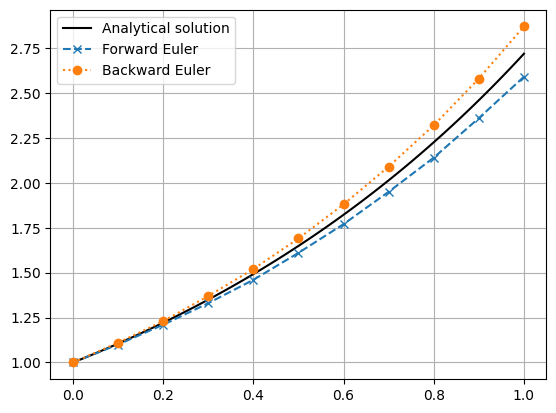

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas

df_forward = pandas.read_csv("exercises/ode/forward.csv")
df_backward = pandas.read_csv("exercises/ode/backward.csv")

fig, axes = plt.subplots()

times = np.linspace(0, 1, 101)

axes.plot(times, np.exp(times), "-", color="k", label="Analytical solution")
axes.plot(df_forward["t"], df_forward["u"], "--x", label="Forward Euler")
axes.plot(df_backward["t"], df_backward["u"], ":o", label="Backward Euler")
axes.legend()
axes.grid()

## ODE example: source transformation

As we see from the plot above, the forward Euler method tends to underestimate the solution, whereas the backward Euler method tends to overestimate it. Let's try to optimise the value of $\theta$ to best match the solution using a gradient-based optimisation method. To do that, we first need the gradient.

The optimisation problem we seek to solve is to minimise some error measure $J$ for the approximation of $u$ by varying $\theta$. That is,
$$
    \min_{\theta\in[0,1]}J(u;\theta).
$$
where the notation $J(u;\theta)$ refers to the implicit dependence of the solution approximation $u$ on $\theta$.

<div class="alert alert-block alert-info">
<b>Exercise</b>
    
Navigate to `session1/exercises/ode` and apply forward mode AD to the `theta_method` subroutine in `theta.f90` with Tapenade, specifying the `theta` argument as independent and the output `u` as dependent.

</div>

<div class="alert alert-block alert-warning">
<b>Solutions</b>
    
<details>

```sh
$ tapenade -head "theta_method(theta)\(u)" theta.f90 
Tapenade 3.16 (develop) - 23 Apr 2025 13:39 - Java 21.0.7 Linux
@@ TAPENADE_HOME=/home/joe/software/tools/tapenade_3.16/bin/..
Diff-liveness analysis turned off
@@ Created ./theta_d.f90 
@@ Created ./theta_d.msg
$ cat theta_d.f90
```
gives
```fortran
!        Generated by TAPENADE     (INRIA, Ecuador team)
!  Tapenade 3.16 (develop) - 23 Apr 2025 13:39
!
!  Differentiation of theta_method in forward (tangent) mode:
!   variations   of useful results: u
!   with respect to varying inputs: theta
!   RW status of diff variables: u:out theta:in
SUBROUTINE THETA_METHOD_D(theta, thetad, filename, u, ud)
  IMPLICIT NONE
  REAL, INTENT(IN) :: theta
  REAL, INTENT(IN) :: thetad
  CHARACTER(len=*), INTENT(IN) :: filename
  REAL, INTENT(OUT) :: u
  REAL, INTENT(OUT) :: ud
  REAL, PARAMETER :: dt=0.1
  REAL, PARAMETER :: end_time=1.0
  REAL :: t
  REAL :: u_
  REAL :: u_d
! Create a CSV file for output
  OPEN(unit=10, file=filename) 
  WRITE(unit=10, fmt='(''t,u'')') 
! Initialisation
  t = 0.0
  CALL INITIAL_CONDITION(u_)
  WRITE(unit=10, fmt=100) t, u_
  ud = 0.0
  u_d = 0.0
! Timestepping loop
  DO WHILE (t .LT. end_time - 1e-05)
    CALL THETA_STEP_D(u, ud, u_, u_d, dt, theta, thetad)
    u_d = ud
    u_ = u
    t = t + dt
    WRITE(unit=10, fmt=100) t, u
  END DO
  CLOSE(unit=10) 
 100 FORMAT(f4.2,',',f4.2)
END SUBROUTINE THETA_METHOD_D

!  Differentiation of theta_step in forward (tangent) mode:
!   variations   of useful results: u
!   with respect to varying inputs: u_ theta
SUBROUTINE THETA_STEP_D(u, ud, u_, u_d, dt, theta, thetad)
  IMPLICIT NONE
! solution at current timestep
  REAL, INTENT(OUT) :: u
  REAL, INTENT(OUT) :: ud
! solution at previous timestep
  REAL, INTENT(IN) :: u_
  REAL, INTENT(IN) :: u_d
! Timestep length
  REAL, INTENT(IN) :: dt
! Theta parameter
  REAL, INTENT(IN) :: theta
  REAL, INTENT(IN) :: thetad
  REAL :: temp
  temp = u_/(-(dt*theta)+1)
  ud = (dt*(1-theta)+1)*(u_d+temp*dt*thetad)/(1-dt*theta) - temp*dt*&
&   thetad
  u = (dt*(1-theta)+1)*temp
END SUBROUTINE THETA_STEP_D
```

</details>

## ODE example: optimisation with gradient descent

Let's solve this ODE problem with one of the simplest gradient-based optimisation approaches: gradient descent. This amounts to an initial guess $\theta_0$, followed by iterative updates
$$
    \theta_{k+1}=\theta_k+\alpha_k\:p_k,
$$
where $\alpha_k$ is the step length at iteration $k$ and $p_k$ is the descent direction. For gradient descent, we simply take
$$
    p_k=-\frac{\mathrm{d}J_k}{\mathrm{d}\theta_k}.
$$

Since we know the analytical solution for this problem, we may make an 'artifical' choice of cost function such as
$$
    J(u;\theta)=(u(1)-\mathrm{e}^1)^2,
$$
where here $\mathrm{e}^1$ is the analytical solution at the end time $t=1$.

<div class="alert alert-block alert-info">
<b>Exercise</b>
    
The gradient descent algorithm is implemented for our ODE problem in `session1/exercises/ode/gradient_descent.f90`. However, there is another missing piece: you will also need to differentiate the cost function. Convince yourself you are satisfied with the output.

</div>

<div class="alert alert-block alert-warning">
<b>Solutions</b>
    
<details>

```sh
$ tapenade cost_function.f90 
Tapenade 3.16 (develop) - 23 Apr 2025 13:39 - Java 21.0.7 Linux
@@ TAPENADE_HOME=/home/joe/software/tools/tapenade_3.16/bin/..
Command: Took subroutine cost_function as default differentiation root
Diff-liveness analysis turned off
@@ Created ./cost_function_d.f90 
@@ Created ./cost_function_d.msg
cat cost_function_d.f90
```
gives
```fortran
!        Generated by TAPENADE     (INRIA, Ecuador team)
!  Tapenade 3.16 (develop) - 23 Apr 2025 13:39
!
!  Differentiation of cost_function in forward (tangent) mode:
!   variations   of useful results: j
!   with respect to varying inputs: u
!   RW status of diff variables: j:out u:in
! Cost function evaluating the l2 error at the end time against the analytical solution u(t)=exp(t)
SUBROUTINE COST_FUNCTION_D(u, ud, j, jd)
  IMPLICIT NONE
  REAL, INTENT(IN) :: u
  REAL, INTENT(IN) :: ud
  REAL, INTENT(OUT) :: j
  REAL, INTENT(OUT) :: jd
  INTRINSIC EXP
  REAL, PARAMETER :: e=EXP(1.0)
  jd = 2*(u-e)*ud
  j = (u-e)**2
END SUBROUTINE COST_FUNCTION_D
```

<div class="alert alert-block alert-warning">
<b>Details on running the code</b>

<details>

Compile with
```sh
$ gfortran gradient_descent.f90 -o gradient_descent
```
and then run with
```sh
$ ./gradient_descent
$ ls
backward.csv        forward.csv           optimised.csv
backward_euler.f90  forward_euler.f90     theta.f90
cost_function.f90   gradient_descent.f90  theta_progress.csv
```

</details>
</div>

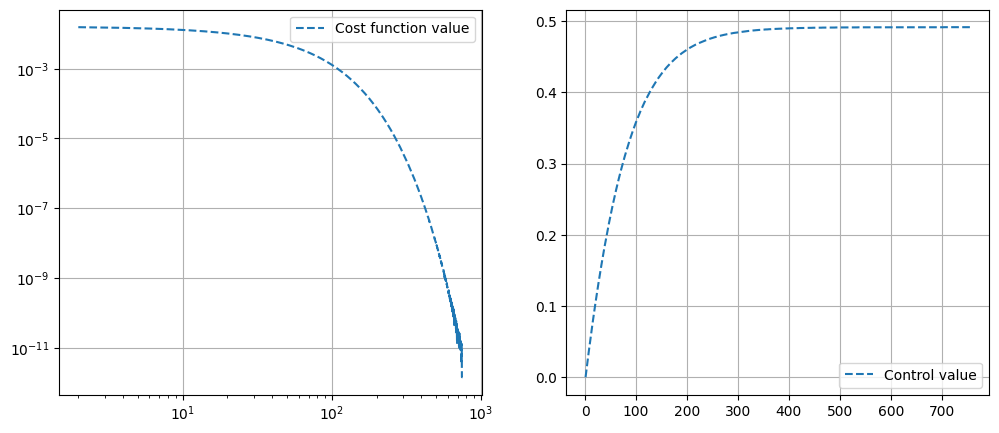

In [3]:
df_opt = pandas.read_csv("exercises/ode/optimisation_progress.csv")

costs = np.array(df_opt["J"])
costs[0] = np.nan  # Remove the first entry because it's not actually a cost function value
controls = np.array(df_opt["theta"])

fig, axes = plt.subplots(ncols=2, figsize=(12, 5))
axes[0].loglog(df_opt["it"], costs, "--", label="Cost function value")
axes[0].legend()
axes[0].grid()
axes[1].plot(df_opt["it"], df_opt["theta"], "--", label="Control value")
axes[1].legend()
axes[1].grid()

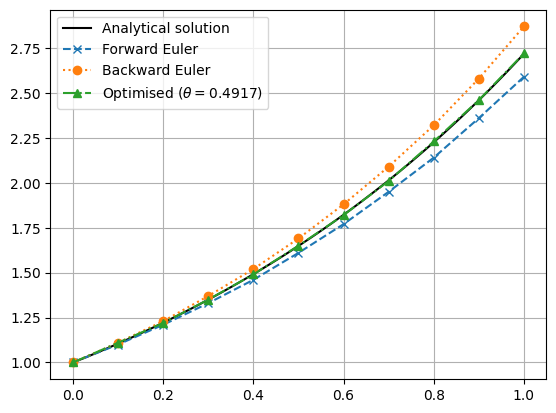

In [4]:
df_optimised = pandas.read_csv("exercises/ode/optimised.csv")

fig, axes = plt.subplots()
axes.plot(times, np.exp(times), "-", color="k", label="Analytical solution")
axes.plot(df_forward["t"], df_forward["u"], "--x", label="Forward Euler")
axes.plot(df_backward["t"], df_backward["u"], ":o", label="Backward Euler")
axes.plot(df_optimised["t"], df_optimised["u"], "-.^", label=rf"Optimised ($\theta={controls[-1]:.4f}$)")
axes.legend()
axes.grid()

As we might hope, the optimised value of $\theta$ gives a much better approximation.

## Validation: the Taylor test

<div class="alert alert-block alert-danger">
<b>TODO</b>    
</div>

## Approach 2: Operator overloading

<div class="alert alert-block alert-danger">
<b>TODO</b>
</div>

#### Operator overloading tools:

* LLVM
    * [Enzyme](https://enzyme.mit.edu) <!-- is a plugin that performs automatic differentiation (AD) of statically analyzable LLVM. By operating on the LLVM level Enzyme is able to perform AD across a variety of languages (C/C++, Fortran , Julia, etc.) and perform optimization prior to AD -->
* C/C++
    * About 2 dozen AD tools!
    * e.g., [ADIC](https://www.mcs.anl.gov/research/projects/adic), [ADOL-C](https://github.com/coin-or/ADOL-C), [Torch Autograd](https://pytorch.org/tutorials/advanced/cpp_autograd.html), [CoDiPack](https://github.com/SciCompKL/CoDiPack), [Sacado](https://docs.trilinos.org/dev/packages/sacado/doc/html/index.html), [dco/c++](https://nag.com/automatic-differentiation) [commercial]
* Fortran
    * [Differentia](https://github.com/Nicholaswogan/Differentia), [lots of abandonware...]
* Python
    * [PyADOL-C](https://github.com/b45ch1/pyadolc), [Jax](https://github.com/jax-ml/jax), [PyTorch Autograd](https://pytorch.org/docs/stable/autograd.html)
* Julia
    * About 2 dozen AD tools! https://juliadiff.org/
    * e.g., Enzyme, [Zygote](https://fluxml.ai/Zygote.jl/stable), [ForwardDiff](https://juliadiff.org/ForwardDiff.jl/stable)
    * [DifferentiationInterface](https://www.juliapackages.com/p/differentiationinterface)
* Domain-specific
    * [dolfin-adjoint/pyadjoint](https://github.com/dolfin-adjoint/pyadjoint) (Python/UFL - Firedrake & FEniCS)
* And many more! https://autodiff.org/?module=Tools

## Calculating the *full* Jacobian

<div class="alert alert-block alert-info">
<b>Question</b>

Given a map $\mathbf{f}$, some input $\mathbf{x}$, and some seed $\dot{\mathbf{x}}$, we have the Jacobian vector product
$$\nabla\mathbf{f}(\mathbf{x})\dot{\mathbf{x}}.$$

*How can we use this to compute the full Jacobian matrix $\nabla\mathbf{f}(\mathbf{x})$?*

</div>

<div class="alert alert-block alert-warning">
<b>Solution</b>
    
<details>
$$\nabla F(x)=\nabla F(x)I_n=\nabla F(x)\begin{bmatrix}e_1,e_2,\dots,e_n\end{bmatrix}.$$

Apply JVP to the $n$ canonical unit vectors.
</details>
</div>

<div class="alert alert-block alert-danger">
<b>TODO</b>
Exercise in notebook using a simple finite difference stencil corresponding to a tridiagonal matrix.
</div>

## Sparse AD

We can compute the full Jacobian with
$$\nabla\mathbf{f}(\mathbf{x})=\nabla\mathbf{f}(\mathbf{x})I_n=\nabla\mathbf{f}(\mathbf{x})\begin{bmatrix}e_1,e_2,\dots,e_n\end{bmatrix}.$$

* But what about when $n$ gets very large?
* And what about when the Jacobian is sparse?

## Sparse AD: simplest case - diagonal Jacobian

Suppose $\nabla\mathbf{f}(\mathbf{x})$ is diagonal, say

$$\nabla\mathbf{f}(\mathbf{x})=\begin{bmatrix}f_1\\& f_2\\ & & \ddots\\ & & & f_n\end{bmatrix}.$$

Then, for a seed vector $\dot{\mathbf{x}}=\begin{bmatrix}\dot{x}_1 & \dot{x}_2 & \dots & \dot{x}_n\end{bmatrix}^T$, we have

$$
\nabla\mathbf{f}(\mathbf{x})\dot{\mathbf{x}}
=\begin{bmatrix}f_1\\& f_2\\ & & \ddots\\ & & & f_n\end{bmatrix}
\begin{bmatrix}\dot{x}_1 \\ \dot{x}_2 \\ \vdots \\ \dot{x}_n\end{bmatrix}
=\begin{bmatrix}f_1\dot{x}_1 \\ f_2\dot{x}_2 \\ \vdots \\ f_n\dot{x}_n\end{bmatrix}.
$$

We can then back out the full Jacobian by putting each entry on the diagonal.

## Sparse AD: what colour is your Jacobian?

<div class="alert alert-block alert-danger">
<b>TODO:</b> Orthogonal columns simple demo
</div>

<img src="images/colours.png" width=600 />
<div><strong>Figure 2:</strong> Jacobian colouring diagram taken from Gebremedhin, et al (2005).</div>

## Sparse AD: performance comparison

<img src="images/runtimes.png" width=600 />
<div><strong>Figure 3:</strong> Performance comparison for different Jacobian computation approaches for solving the Gray-Scott equation using a finite difference approach, taken from Wallwork et al. (2019). PETSc was used for numerical solvers and ADOL-C for AD. The $N\times N$ notation in the subcaptions refers to the grid dimension.</div>

<!-- Run on a Knights Landing node at Argonne National Laboratory -->

<div class="alert alert-block alert-danger">
<b>TODO</b>
More diagrams from ADOL-C/PETSc preprint comparing runtimes
</div>

## Levels of abstraction

* Low-level: elementary operators, e.g., Tapenade, ADIC, ADOL-C.
* Medium-level: API calls, e.g., AD in PETSc.
* High-level: high-level maths, e.g., Pyadjoint/dolfin-adjoint.

<div class="alert alert-block alert-danger">
<b>TODO</b>
Example code snippets of the above
</div>

## References

* R. E. Wengert. *A simple automatic derivative evaluation program*. Communications
of the ACM, 7(8):463–464, 1964.
* A. Griewank. *Achieving logarithmic growth of temporal and spatial complexity in
reverse automatic differentiation.* Optimization Methods & Software, 1:35–54, 1992.
* D. Cortild, et al. *A Brief Review of Automatic Differentiation.* (2023).
* A. H. Gebremedhin, et al. *What color is your Jacobian? Graph coloring for computing derivatives* (2005). SIAM review, 47(4), pp.629-705.
* J. G. Wallwork, P. Hovland, H. Zhang, and O. Marin, *Computing derivatives for petsc adjoint solvers using algorithmic differentiation* (2019), arXiv preprint arXiv:1909.02836.